In [1]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F

# Preparing the dataset

In [2]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/main/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
    content = requests.get(URL + FILENAME).content
    (PATH / FILENAME).open("wb").write(content)

In [3]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

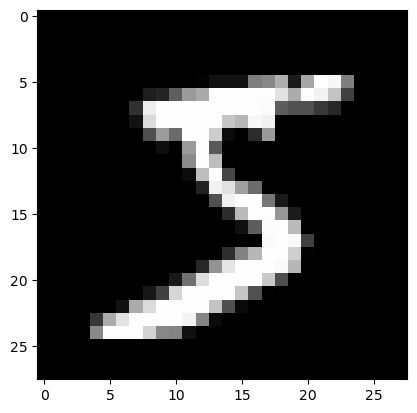

In [4]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
pyplot.show()

Putting the data into PyTorch ecosystem

In [5]:
x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
print(x_train, y_train)
print(x_train.shape, y_train.shape) # The size of each x is 784, which is 28**2.
print(y_train.min(), y_train.max()) # You can see the range is 0..9

bs = 64
train_dataset = DataLoader(TensorDataset(x_train, y_train), batch_size=bs)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784]) torch.Size([50000])
tensor(0) tensor(9)


# Defining the model

In [6]:
class MnistCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)
        self.logsoftmax = nn.LogSoftmax(dim=1)
        
    def forward(self, xb):
        # xb is a batch, its first dimension corresponding to samples index in the batch.
        # Since the first convolution layer assumes there to be one channel,
        # we have to unsqueeze xb to create another dimension corresponding to the channel index.
        # Therefore the new shape becomes (number of samples, 1, 28, 28)
        xb = xb.reshape(-1, 1, 28, 28) 
        xb = F.relu(self.conv1(xb)) 
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        # Here 4 is the pooling kernel; that's to say, 
        # if the input is 10×4×4, then the output is 10×1×1.
        # Therefore after xb.view, the output dimension becomes 10,
        # or to be more precise, number of sample in input batch × 10.
        xb = F.avg_pool2d(xb, 4)
        xb = xb.view(-1, xb.size(1))
        # Be cautious about whether to add the activation function here: 
        # it depends on the loss function and how the output of the model is interpreted.
        return self.logsoftmax(xb) 


# Training

In [7]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [15]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = MnistCNN().to(dev)
x_valid = x_valid.to(dev)
y_valid = y_valid.to(dev)
loss_func = nn.NLLLoss()

epoch:   0   accuracy: 0.109000
epoch:   1   accuracy: 0.109000
epoch:   2   accuracy: 0.109000
epoch:   3   accuracy: 0.226900
epoch:   4   accuracy: 0.261200
epoch:   5   accuracy: 0.345800
epoch:   6   accuracy: 0.387400
epoch:   7   accuracy: 0.466600
epoch:   8   accuracy: 0.539500
epoch:   9   accuracy: 0.614500
epoch:  10   accuracy: 0.665400
epoch:  11   accuracy: 0.712100
epoch:  12   accuracy: 0.747000
epoch:  13   accuracy: 0.779700
epoch:  14   accuracy: 0.803400
epoch:  15   accuracy: 0.819900
epoch:  16   accuracy: 0.829800
epoch:  17   accuracy: 0.838000
epoch:  18   accuracy: 0.845000
epoch:  19   accuracy: 0.851400
epoch:  20   accuracy: 0.856500
epoch:  21   accuracy: 0.861000
epoch:  22   accuracy: 0.862900
epoch:  23   accuracy: 0.863900
epoch:  24   accuracy: 0.866100
epoch:  25   accuracy: 0.868600
epoch:  26   accuracy: 0.868000
epoch:  27   accuracy: 0.869800
epoch:  28   accuracy: 0.874300
epoch:  29   accuracy: 0.876300
epoch:  30   accuracy: 0.875400
epoch:  

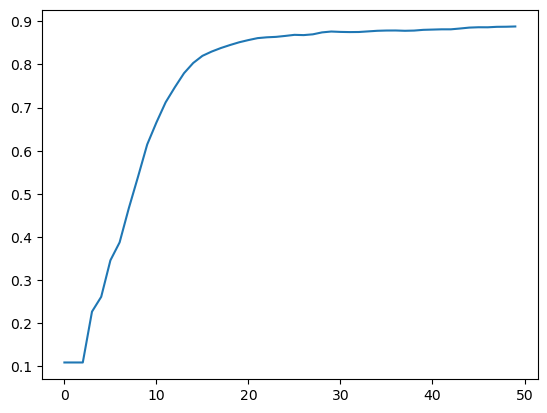

In [16]:
n_epoch = 50
lr = 0.1
max_samples = 100

accuracies = np.zeros(n_epoch)

optimizer = torch.optim.SGD(model.parameters(), lr=lr)

for epoch in range(n_epoch):
    model.train()
    i = 0
    
    for xb, yb in train_dataset:
        if i == max_samples:
            break

        xb = xb.to(dev)
        yb = yb.to(dev)

        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        optimizer.step()        
        optimizer.zero_grad()
        i += 1
    
    model.eval()
    with torch.no_grad():
        acc = accuracy(model(x_valid), y_valid).item()
        accuracies[epoch] = acc
        print(f"epoch: {epoch:>3d}   accuracy: {acc:>5f}")
        
pyplot.plot(accuracies)

epoch:   0   accuracy: 0.908300
epoch:   1   accuracy: 0.907700
epoch:   2   accuracy: 0.907600
epoch:   3   accuracy: 0.908000
epoch:   4   accuracy: 0.908300
epoch:   5   accuracy: 0.908200
epoch:   6   accuracy: 0.908100
epoch:   7   accuracy: 0.907800
epoch:   8   accuracy: 0.908200
epoch:   9   accuracy: 0.908700
epoch:  10   accuracy: 0.908900
epoch:  11   accuracy: 0.908900
epoch:  12   accuracy: 0.909000
epoch:  13   accuracy: 0.909300
epoch:  14   accuracy: 0.909500
epoch:  15   accuracy: 0.909500
epoch:  16   accuracy: 0.909500
epoch:  17   accuracy: 0.909700
epoch:  18   accuracy: 0.909900
epoch:  19   accuracy: 0.910000
epoch:  20   accuracy: 0.910000
epoch:  21   accuracy: 0.910100
epoch:  22   accuracy: 0.909900
epoch:  23   accuracy: 0.909600
epoch:  24   accuracy: 0.909900
epoch:  25   accuracy: 0.910200
epoch:  26   accuracy: 0.910300
epoch:  27   accuracy: 0.910400
epoch:  28   accuracy: 0.910500
epoch:  29   accuracy: 0.910300
epoch:  30   accuracy: 0.910500
epoch:  

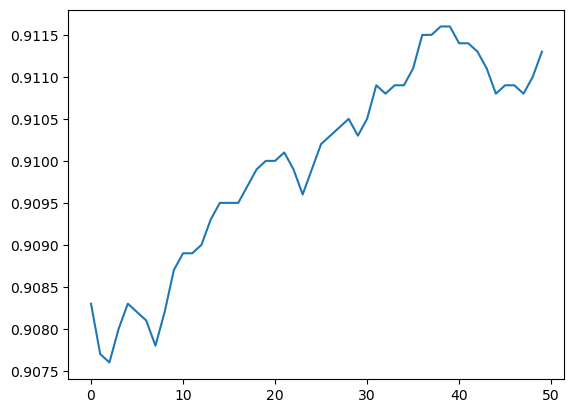

In [17]:
n_epoch = 50
lr = 0.02
max_samples = 100

accuracies = np.zeros(n_epoch)

optimizer = torch.optim.SGD(model.parameters(), lr=lr)

for epoch in range(n_epoch):
    model.train()
    i = 0
    
    for xb, yb in train_dataset:
        if i == max_samples:
            break

        xb = xb.to(dev)
        yb = yb.to(dev)

        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        optimizer.step()        
        optimizer.zero_grad()
        i += 1
    
    model.eval()
    with torch.no_grad():
        acc = accuracy(model(x_valid), y_valid).item()
        accuracies[epoch] = acc
        print(f"epoch: {epoch:>3d}   accuracy: {acc:>5f}")
        
pyplot.plot(accuracies)

In [20]:
with torch.no_grad():
    idxlist_fail = []
    for i in range(y_valid.shape[0]):
        n_pred = model(x_valid[i, :].unsqueeze(0).to(dev)).argmax().item()
        n_real = y_valid[i].item()
        if n_pred != n_real:
            idxlist_fail.append(i) 
    
    print(len(idxlist_fail))

887
